### Human Activity Recognition

Experiments on the WISDM Dataset to explore RNN, ConvNet, and Hybrid architectures for end-to-end sequence learning.

Jay Urbain, PhD

#### References

- [LSTMs for Human Activity Recognition](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)
- [Activity Recognition using Cell Phone Accelerometers](http://www.cis.fordham.edu/wisdm/public_files/sensorKDD-2010.pdf)
- [WIreless Sensor Data Mining Lab](http://www.cis.fordham.edu/wisdm/dataset.php) 

Dataset:  
http://www.cis.fordham.edu/wisdm/dataset.php 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [3]:
df.head(10)

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user         1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


#### Exploration

Training examples by activity type

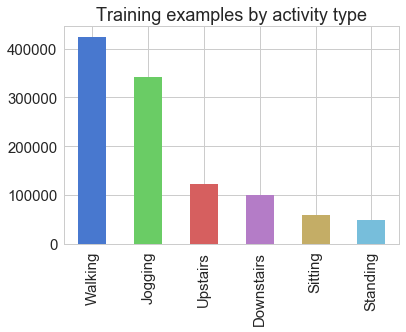

In [5]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

The columns for x-axis, y-axis and z-axis acceleration define our features. 

Training examples by user

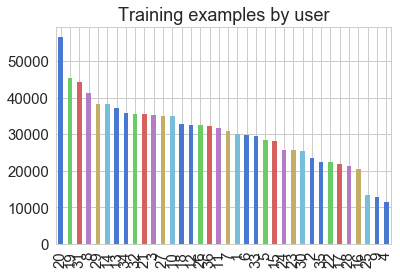

In [6]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

Note: Subjects 9 and 4 need to get more active.

In [7]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

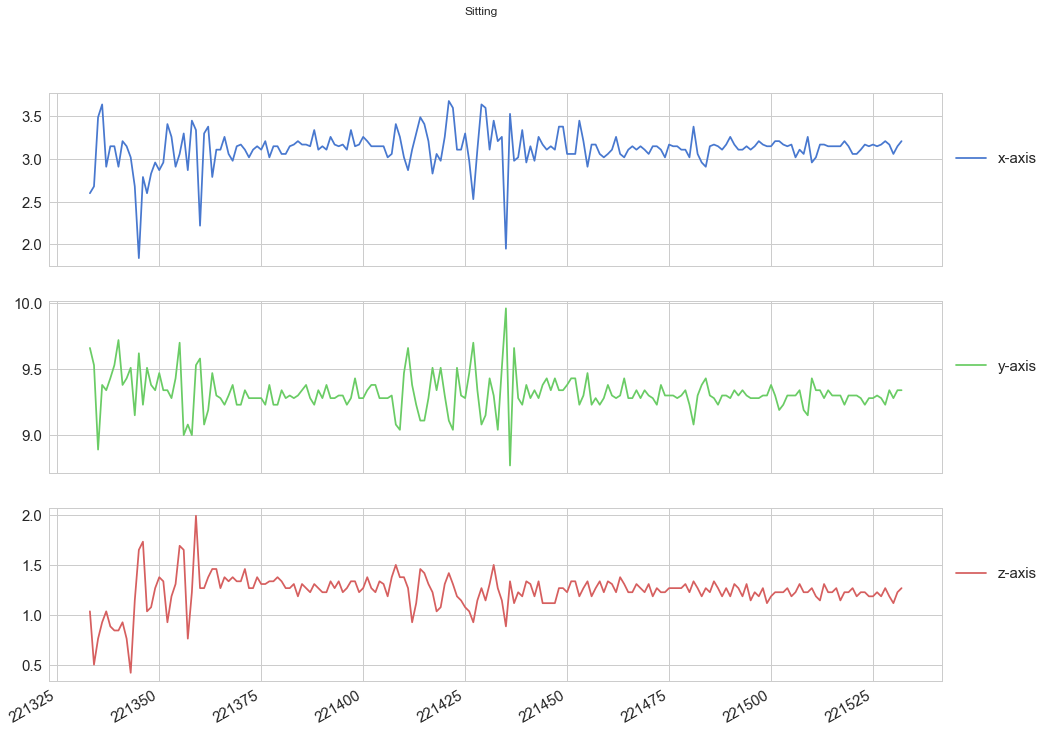

In [8]:
plot_activity("Sitting", df)

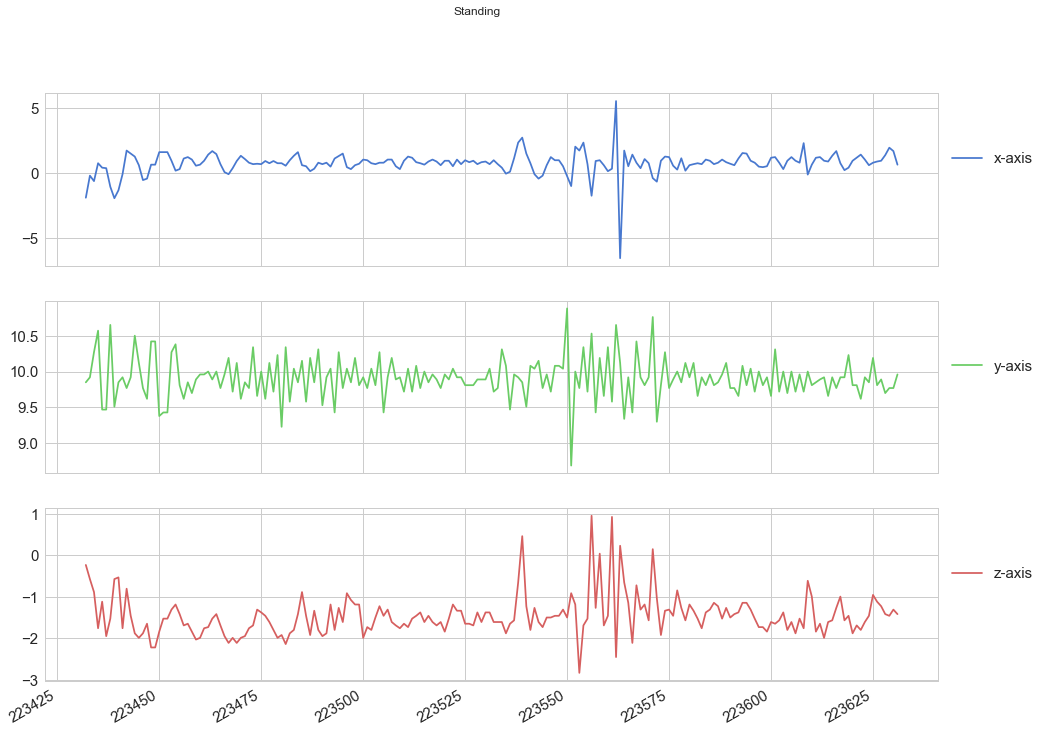

In [9]:
plot_activity("Standing", df)

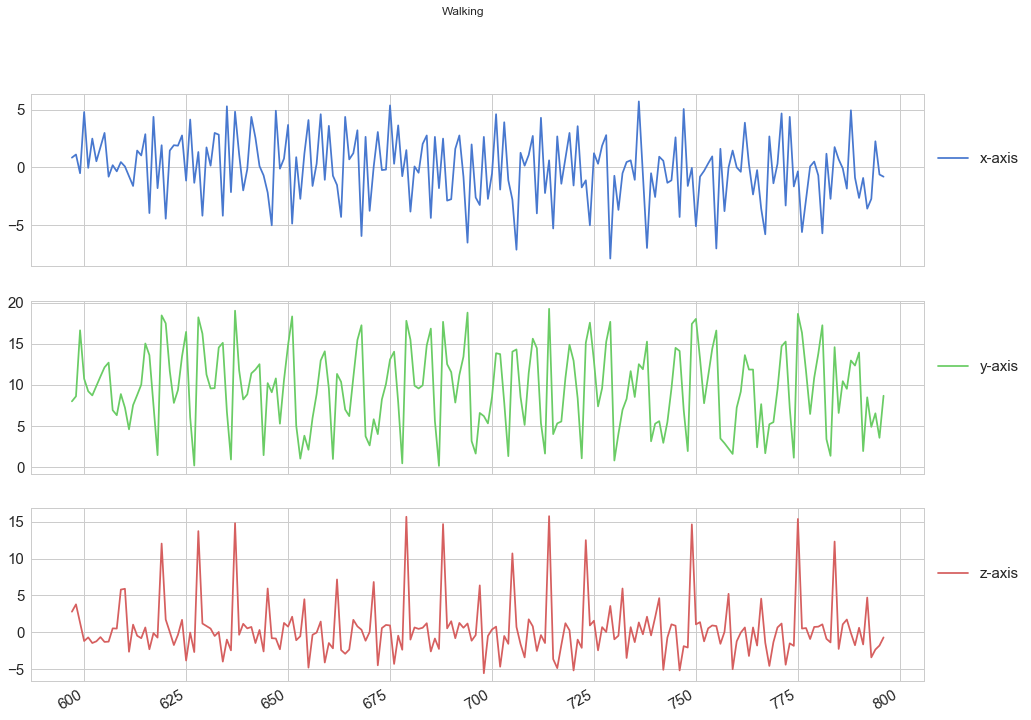

In [10]:
plot_activity("Walking", df)

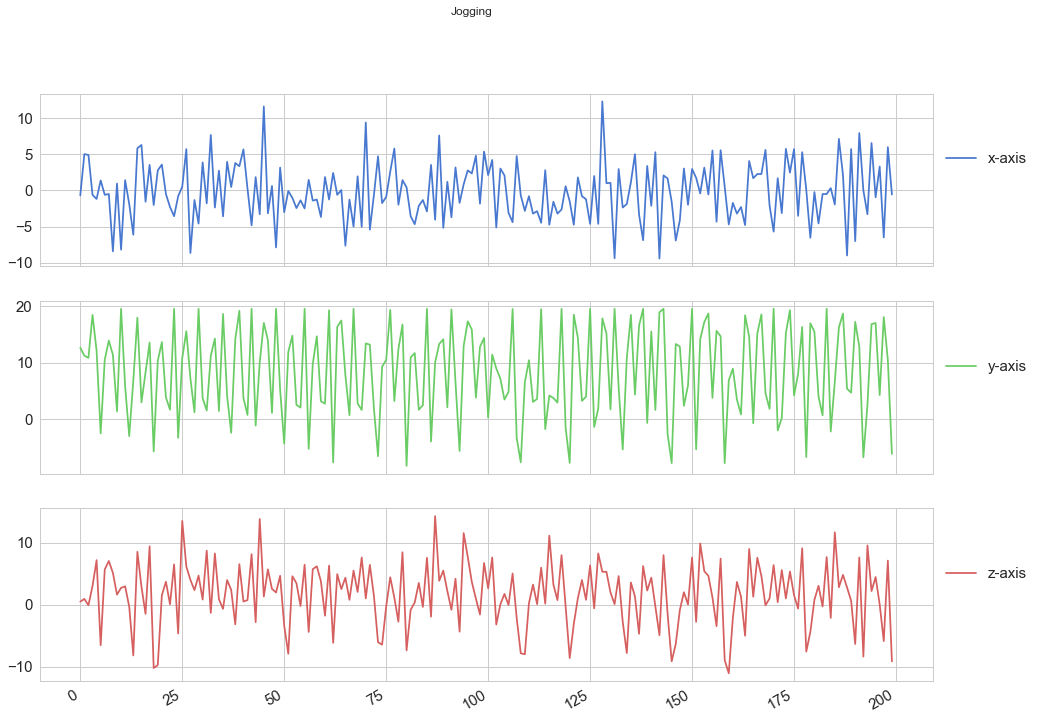

In [11]:
plot_activity("Jogging", df)

### Data preprocessing

LSTM model expects fixed-length sequences as training data. Generate sequences containing 100 (5 sec.) training examples. Or whatever you would like. They used 10 seconds in the original paper.

In [12]:
N_TIME_STEPS = 100
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [13]:
np.array(segments).shape

(54906, 3, 100)

In [14]:
np.array(labels).shape

(54906,)

Transform tensor into sequences of N_TIME_STEPS rows, each containing N_FEATURES (x, y and z). 

For classification, apply one-hot encoding to the classification labels.

In [15]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
print(type(reshaped_segments))
dummy_df = pd.get_dummies(labels)
print(dummy_df[:10])
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

<class 'numpy.ndarray'>
   Downstairs  Jogging  Sitting  Standing  Upstairs  Walking
0           0        1        0         0         0        0
1           0        1        0         0         0        0
2           0        1        0         0         0        0
3           0        1        0         0         0        0
4           0        1        0         0         0        0
5           0        1        0         0         0        0
6           0        1        0         0         0        0
7           0        1        0         0         0        0
8           0        1        0         0         0        0
9           0        1        0         0         0        0


In [16]:
reshaped_segments.shape

(54906, 100, 3)

In [17]:
reshaped_segments[0, 0, :]


array([-0.6946377,  5.012288 ,  4.903325 ], dtype=float32)

In [18]:
labels[0]

array([0., 1., 0., 0., 0., 0.], dtype=float32)

Finally, split the data into training and test (20%) set:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [20]:
print(type(X_train))
len(X_train)

<class 'numpy.ndarray'>


43924

In [21]:
len(X_test)

10982

#### Build the LSTM models

2 LSTM layers with 64 units each, softmax

In [22]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64
N_FEATURES = 3
step = 20
# X_train, X_test, y_train, y_test

In [ ]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers import Input, LSTM, Dense
from keras.models import Model

batch_size = 256
   
# print('X_train shape:', X_train.shape)
# print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()

model.add(LSTM(N_HIDDEN_UNITS, input_shape=(N_TIME_STEPS, N_FEATURES), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
# model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(N_CLASSES, activation='softmax'))
# try using different optimizers and different optimizer configs

# model = LSTM_classifier(N_FEATURES, N_TIME_STEPS, N_HIDDEN_UNITS, N_CLASSES)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50, ########
          shuffle=False,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Using TensorFlow backend.


Build model...
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train...
Train on 43924 samples, validate on 10982 samples
Epoch 1/50
33024/43924 [=====================>........] - ETA: 55s - loss: 0.9935 - acc: 0.6308

2 layer LSTM with dense layer, followed by softmax

In [68]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras import regularizers

batch_size = 256
   
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()

model.add(LSTM(N_HIDDEN_UNITS, input_shape=(N_TIME_STEPS, N_FEATURES), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l1(0.001) ))

model.add(Dense(N_CLASSES, activation='softmax'))
# try using different optimizers and different optimizer configs

# model = LSTM_classifier(N_FEATURES, N_TIME_STEPS, N_HIDDEN_UNITS, N_CLASSES)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          shuffle=False,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

X_train shape: (43920, 200, 3)
X_test shape: (10981, 200, 3)
Build model...
Train...
Train on 43920 samples, validate on 10981 samples
Epoch 1/50
43920/43920 [==============================] - 326s - loss: 1.7509 - acc: 0.4155 - val_loss: 1.6151 - val_acc: 0.4465
Epoch 2/50
43920/43920 [==============================] - 350s - loss: 1.5588 - acc: 0.4366 - val_loss: 1.5027 - val_acc: 0.4269
Epoch 3/50
43920/43920 [==============================] - 327s - loss: 1.4773 - acc: 0.4306 - val_loss: 1.4365 - val_acc: 0.4297
Epoch 4/50
43920/43920 [==============================] - 329s - loss: 1.4218 - acc: 0.4337 - val_loss: 1.3996 - val_acc: 0.4334
Epoch 5/50
43920/43920 [==============================] - 303s - loss: 1.3754 - acc: 0.5882 - val_loss: 1.3401 - val_acc: 0.6802
Epoch 6/50
43920/43920 [==============================] - 297s - loss: 1.2920 - acc: 0.6684 - val_loss: 1.1663 - val_acc: 0.7008
Epoch 7/50
43920/43920 [==============================] - 312s - loss: 1.1322 - acc: 0.7092

4 layer LSTM, dense softmax

In [69]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras import regularizers

# def LSTM_classifier(feature_count, seq_length, rnn_width, class_count):
#   input = Input(shape=(feature_count, seq_length))
#   x = LSTM(rnn_width, return_sequences=True)(input)
# #   x = LSTM(rnn_width, return_sequences=True)(x)
#   x = LSTM(rnn_width)(x)
#   x = Dense(class_count, activation='softmax')(x)
#   return Model(input, x)

batch_size = 256
   
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()

model.add(LSTM(N_HIDDEN_UNITS, input_shape=(N_TIME_STEPS, N_FEATURES), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
# model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l1(0.001) ))
model.add(Dense(N_CLASSES, activation='softmax'))
# try using different optimizers and different optimizer configs

# model = LSTM_classifier(N_FEATURES, N_TIME_STEPS, N_HIDDEN_UNITS, N_CLASSES)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=100,
          shuffle=False,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

X_train shape: (43920, 200, 3)
X_test shape: (10981, 200, 3)
Build model...
Train...
Train on 43920 samples, validate on 10981 samples
Epoch 1/100
43920/43920 [==============================] - 693s - loss: 1.0139 - acc: 0.6111 - val_loss: 0.6156 - val_acc: 0.7887
Epoch 2/100
43920/43920 [==============================] - 665s - loss: 0.7049 - acc: 0.7516 - val_loss: 0.5173 - val_acc: 0.8146
Epoch 3/100
43920/43920 [==============================] - 661s - loss: 0.6105 - acc: 0.7809 - val_loss: 0.4826 - val_acc: 0.8193
Epoch 4/100
43920/43920 [==============================] - 638s - loss: 0.5550 - acc: 0.7987 - val_loss: 0.4423 - val_acc: 0.8292
Epoch 5/100
43920/43920 [==============================] - 646s - loss: 0.5231 - acc: 0.8090 - val_loss: 0.4178 - val_acc: 0.8376
Epoch 6/100
43920/43920 [==============================] - 654s - loss: 0.4851 - acc: 0.8201 - val_loss: 0.3685 - val_acc: 0.8650
Epoch 7/100
43920/43920 [==============================] - 648s - loss: 0.4490 - acc:

KeyboardInterrupt: 

In [75]:
print(X_train.shape)
X_train_r = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
print(X_train_r.shape)
print(X_train[0:3])
X_test_r = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])


(43920, 200, 3)
(43920, 600)
[[[ 1.18        1.08        0.8       ]
  [ 0.34        0.72        0.11      ]
  [ 0.65        1.31        1.23      ]
  ...
  [-1.3075534  -1.0760075  -1.6889231 ]
  [-0.50395286 -0.88532263 -1.6889231 ]
  [-1.1849703  -1.6889231  -1.525479  ]]

 [[17.24       17.24        9.23      ]
  [ 9.23        8.35        8.35      ]
  [ 0.          0.          6.21      ]
  ...
  [ 0.46309182  0.3405087  -0.5720546 ]
  [ 0.7218784  -0.6537767   4.099725  ]
  [-5.366417   -9.493382   -5.134871  ]]

 [[ 0.23        5.98        2.03      ]
  [ 1.18        0.31       -1.53      ]
  [ 0.46        3.34        0.27      ]
  ...
  [ 1.0351465  -1.4982382  -2.0294318 ]
  [-2.1792557  -1.920469   -2.1111538 ]
  [-1.56634    -1.56634    -1.334794  ]]]


1-layer convnet, 1-layer pooling, dropout, dense layer, softmax


In [81]:
from __future__ import print_function

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

batch_size = 256
   
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
# build network layers
model = Sequential()
model.add(Conv1D(64,5,input_shape=(N_TIME_STEPS, N_FEATURES) ))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(N_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          shuffle=False,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)


X_train shape: (43920, 200, 3)
X_test shape: (10981, 200, 3)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 196, 64)           1024      
_________________________________________________________________
activation_3 (Activation)    (None, 196, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 98, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 37638     
Total params: 38,662
Trainable params: 38,662
Non-trainable params

In [ ]:
2*(1-layer convnet, 1-layer pooling), dropout, softmax

In [82]:
from __future__ import print_function

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

batch_size = 256
epochs = 30

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
# build network layers
model = Sequential()
model.add(Conv1D(64,5,input_shape=(N_TIME_STEPS, N_FEATURES) ))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(128,5,input_shape=(N_TIME_STEPS, N_FEATURES) ))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(N_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          shuffle=False,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)


X_train shape: (43920, 200, 3)
X_test shape: (10981, 200, 3)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 196, 64)           1024      
_________________________________________________________________
activation_4 (Activation)    (None, 196, 64)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 98, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 94, 128)           41088     
_________________________________________________________________
activation_5 (Activation)    (None, 94, 128)           0         
_________________________________________________________________


2*(1-layer convnet, 1-layer pooling), dropout, flatten, 1-layer LSTM, softmax

In [152]:
from __future__ import print_function

from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

batch_size = 256
epochs = 50

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
# build network layers
model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
#             activation='relu', padding='same'), input_shape=self.input_shape))
    
model.add(Conv1D(64, 5, padding='same', activation='relu', input_shape=(N_TIME_STEPS, N_FEATURES)) )
model.add(MaxPool1D(pool_size=2)) 
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, padding='same', activation='relu') ) 
model.add(MaxPool1D(pool_size=2)) 
model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(50,return_sequences=True))

model.add(Flatten())
# model.add(LSTM(ndim=150, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(N_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          shuffle=False,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)



X_train shape: (43924, 100, 3)
X_test shape: (10982, 100, 3)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 100, 64)           1024      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 50, 128)           41088     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 25, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 25, 128)           0         
_________________________________________________________________


In [153]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [189]:
# print(X_train.shape)
tensor = np.reshape(X_train[0,:,:], (1, X_train.shape[1], X_train.shape[2]) )
print(tensor.shape)
activations = activation_model.predict(tensor)
print(activations[0].shape)
first_layer_activation = activations[0]
print(first_layer_activation.shape)
print(activations[len(activations)-1])

(1, 100, 3)
(1, 100, 64)
(1, 100, 64)
[[1.8866011e-08 5.2392517e-09 2.7133894e-13 1.0377289e-12 3.2479871e-08
  1.0000000e+00]]


['conv1d_9', 'max_pooling1d_9', 'dropout_9', 'conv1d_10', 'max_pooling1d_10', 'dropout_10', 'gru_5', 'flatten_5', 'dense_8']
1.0 128.0


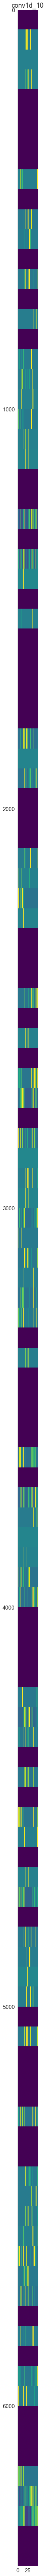

In [188]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name)
print(layer_names)
images_per_row = 1

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    
    if layer_name != 'conv1d_10':
        continue
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
#             print(layer_activation.shape)
            channel_image = layer_activation[0,
                                             :, 
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    print( scale * display_grid.shape[1],
                        scale * display_grid.shape[0])
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    #plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()
#plt.colorbar()

96 -56 39


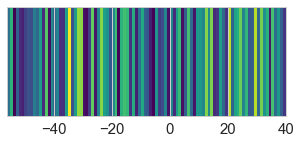

In [173]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2

pos = np.arange(-56,40) #there are 96 numbers from -56 to 39
print (len(pos), pos.min(), pos.max())
p = np.random.rand(len(pos))
p= p/np.sum(p)

a= np.random.choice(pos, size=4000, p=p) 
# now a contains 4000 numbers between -56 and 39

bins=np.arange(-56,41) #there are 96 bins, hence 97 edges from -56 to 40
hist, edges = np.histogram(a, bins)
hist=hist[np.newaxis,:]

extent=[bins.min(), bins.max(),0,1]
plt.imshow(hist, aspect = "auto", cmap="viridis", extent=extent)
plt.gca().set_yticks([])
plt.show()


100 0 99


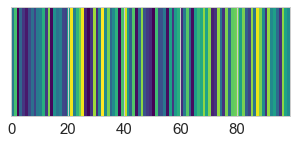

In [174]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2

pos = np.arange(0,100) #there are 96 numbers from -56 to 39
print (len(pos), pos.min(), pos.max())
p = np.random.rand(len(pos))
p= p/np.sum(p)

a= np.random.choice(pos, size=4000, p=p) 
# now a contains 4000 numbers between -56 and 39

bins=np.arange(0, 100) #there are 96 bins, hence 97 edges from -56 to 40
hist, edges = np.histogram(a, bins)
hist=hist[np.newaxis,:]

extent=[bins.min(), bins.max(),0,1]
plt.imshow(hist, aspect = "auto", cmap="viridis", extent=extent)
plt.gca().set_yticks([])
plt.show()

In [122]:
from __future__ import print_function

from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

batch_size = 256
   
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
# build network layers
model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
#             activation='relu', padding='same'), input_shape=self.input_shape))

# This returns a tensor
inputs = Input(shape=(N_TIME_STEPS, N_FEATURES))

conv_1 = Conv1D(64, 5, padding='same', activation='relu', input_shape=(N_TIME_STEPS, N_FEATURES))(inputs)
maxpool_1 = MaxPool1D(pool_size=2)(conv_1)
dropout_1 = Dropout(0.2)(maxpool_1)
conv_2 = Conv1D(128, 5, padding='same', activation='relu')(dropout_1)
maxpool_2 = MaxPool1D(pool_size=2)(conv_2) 
dropout_2 = Dropout(0.2)(maxpool_2)
#model.add(LSTM(N_HIDDEN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_3 = GRU(50,return_sequences=True)(dropout_2)
flat_4 = Flatten()(gru_3)
# model.add(LSTM(ndim=150, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
predictions = Dense(N_CLASSES, activation='softmax')(flat_4)
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())
print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          shuffle=False,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)



X_train shape: (43920, 200, 3)
X_test shape: (10981, 200, 3)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 3)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 64)           1024      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 128)          41088     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________


KeyboardInterrupt: 